# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [7]:
from google.colab import files
import pandas as pd


uploaded = files.upload()


file_name = "bikes_rent.csv"


data = pd.read_csv(file_name, encoding='cp1251')


# Виведення перших 5 рядків датафрейму
data.head(5)

Saving bikes_rent.csv to bikes_rent (3).csv


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

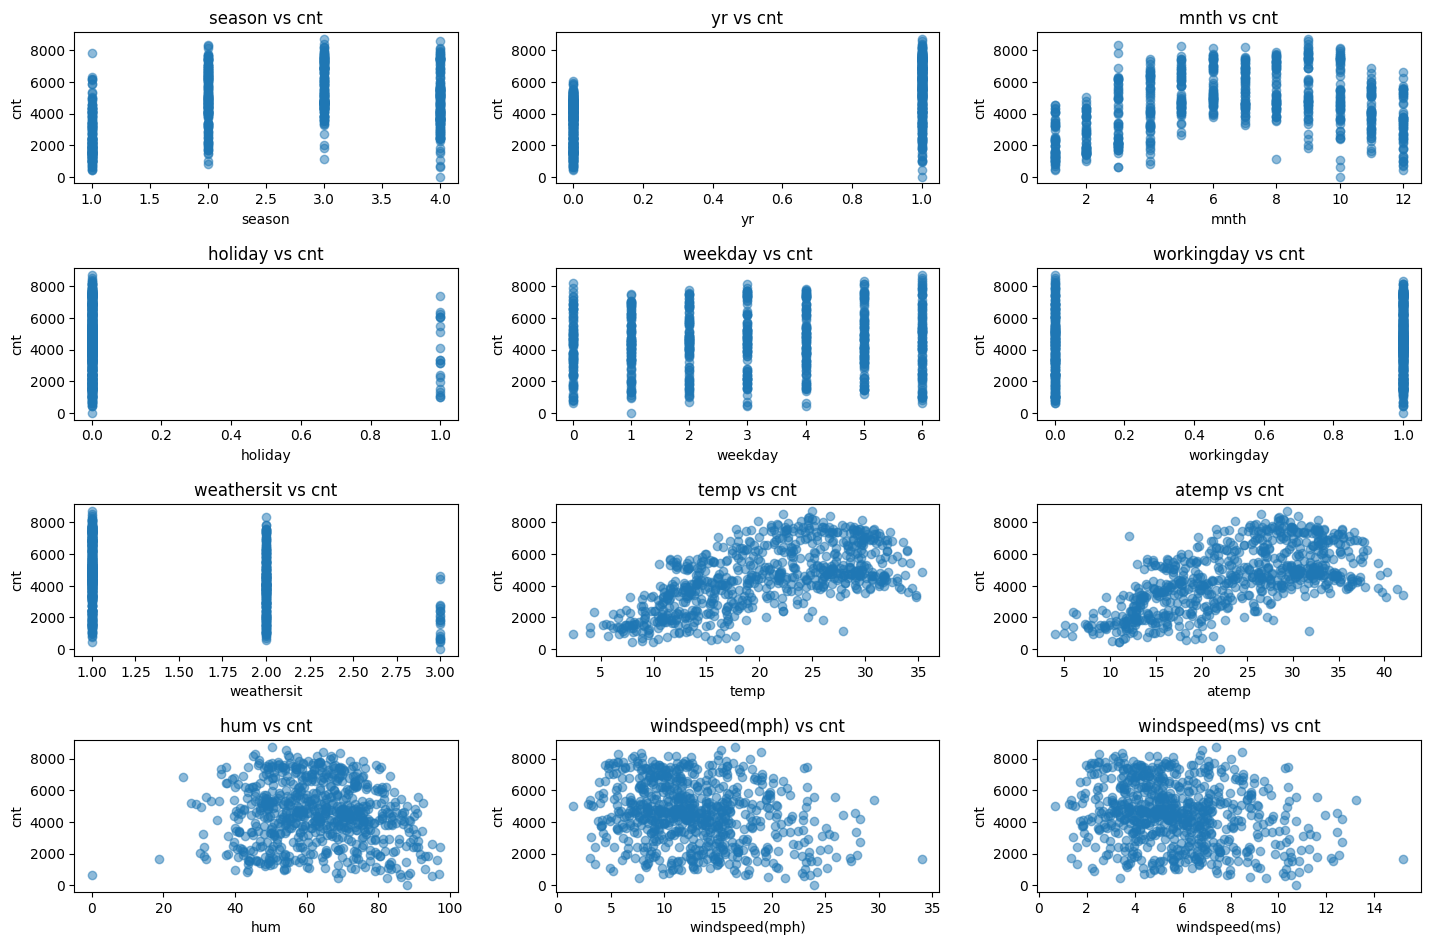

In [9]:

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('bikes_rent.csv')

attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=4.0)

for i, attribute in enumerate(attributes):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(df[attribute], df['cnt'], alpha=0.5)
    axes[row, col].set_title(f'{attribute} vs cnt')
    axes[row, col].set_xlabel(attribute)
    axes[row, col].set_ylabel('cnt')

plt.show()

Питання:
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно


Характер залежності:
За графіком можна визначити, чи існує чітка тенденція чи закономірність кількості оренд на місяць. Якщо на графіку видно, що кількість орендних договорів змінюється лінійно, квадратично або якимось іншим чином, це свідчить про характер залежності.

Ознаки, що вказують на лінійну залежність

temp (градуси Цельсія): temp (градуси Цельсія): якщо спостерігається лінійна тенденція, коли кількість прокатів збільшується в міру підвищення температури, це може свідчити про лінійну залежність.
atemp (температура в градусах Цельсія): аналогічно до температури, але враховує відчуття температури.
Однак важливо відзначити, що це загальні припущення та реальна залежність може бути складнішою. Для оцінки ступеня залежності між змінними рекомендується провести детальніше дослідження, можливо, з використанням лінійної регресії або кореляційного аналізу.

# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [11]:
import pandas as pd

df = pd.read_csv('bikes_rent.csv')

correlations = df.iloc[:, :-1].corrwith(df['cnt'])

print("Кореляції з цільовою змінною (cnt):")
print(correlations)


Кореляції з цільовою змінною (cnt):
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

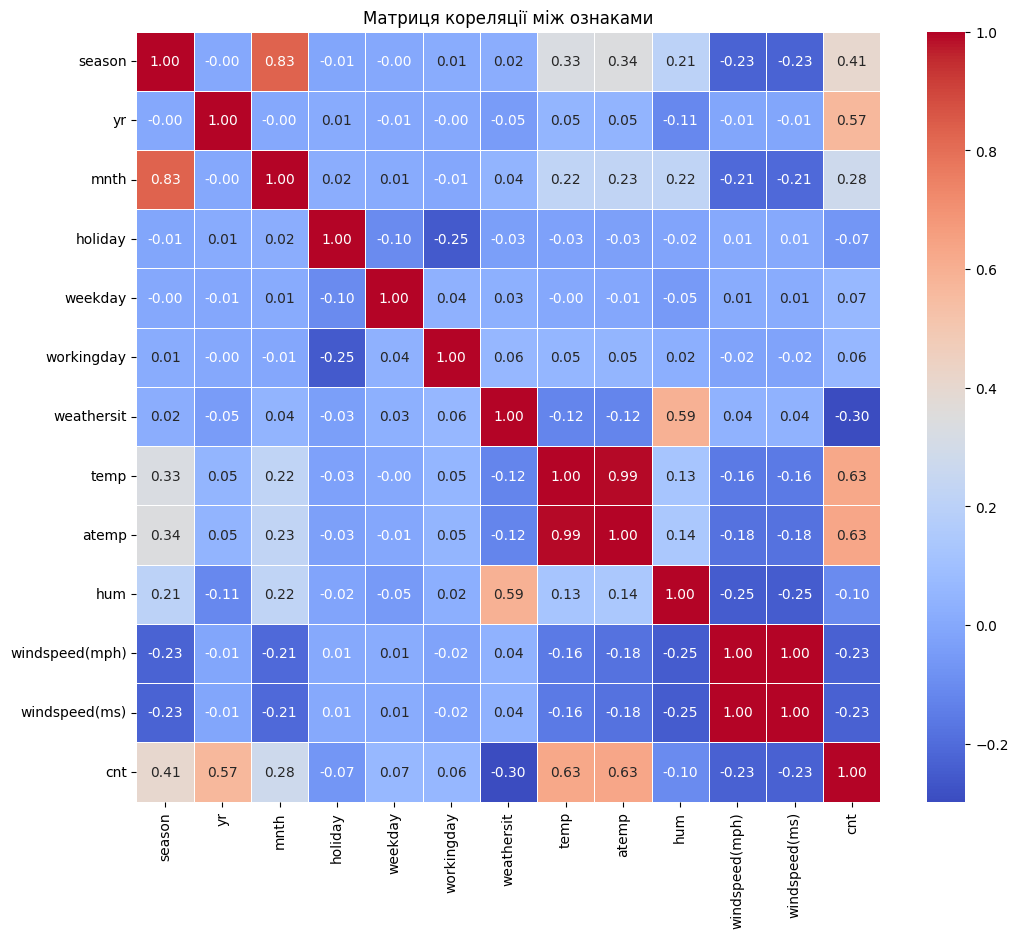

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('bikes_rent.csv')

correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матриця кореляції між ознаками')
plt.show()


# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [13]:
import pandas as pd

df = pd.read_csv('bikes_rent.csv')

selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

correlation_matrix = df[selected_features].corr()

print("Попарні кореляції:")
print(correlation_matrix)


Попарні кореляції:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


# Завдання 4

Виведіть середні ознаки

In [14]:
import pandas as pd

df = pd.read_csv('bikes_rent.csv')

mean_values = df.mean()
print("Середні значення ознак:")
print(mean_values)


Середні значення ознак:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [15]:
import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

regressor = LinearRegression()
regressor.fit(X, y)

weights = list(zip(df.columns[:-1], regressor.coef_))
print("Ваги моделі:")
for feature, weight in weights:
    print(f"{feature}: {weight}")


Ваги моделі:
season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [18]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)

weights_ridge = list(zip(df.columns[:-1], ridge_regressor.coef_))
print("Ваги Ridge регресора:")
for feature, weight in weights_ridge:
    print(f"{feature}: {weight}")

weights_lasso = list(zip(df.columns[:-1], lasso_regressor.coef_))
print("\nВаги Lasso регресора:")
for feature, weight in weights_lasso:
    print(f"{feature}: {weight}")


Ваги Ridge регресора:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843

Ваги Lasso регресора:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

alphas = [0.1, 0.5, 1, 5, 10]

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Ваги для Lasso регресора:")
print(coefs_lasso)

print("\nВаги для Ridge регресора:")
print(coefs_ridge)


Ваги для Lasso регресора:
[[ 509.45281498 2040.25621742  -38.88943663 -515.55808989   69.04981422
   120.16602822 -610.34503326   49.67420564   71.3095701   -10.20502104
   -38.18953571   -0.        ]
 [ 508.16337251 2038.46736671  -38.52894265 -501.82437277   69.0000178
   119.40195528 -607.77770832   50.43530221   70.67918619  -10.27060435
   -38.25722098   -0.        ]
 [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 493.58177992 2018.43723444  -34.45916082 -345.95153653   68.59596627
   110.99623849 -578.41834305   52.92962331   69.16782835  -11.03996141
   -38.82171573   -0.        ]
 [ 477.32591467 1996.24931816  -29.92697086 -171.77719511   68.25910797
   101.79300668 -545.45447186   51.34556518   71.49410924  -11.91744494
   -39.30755407   -0.        ]]

Ваги для Ridge регресора:
[[ 509.57821593 2039.53571054  -38.92891535 -516.29762424   69.06827585
 

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

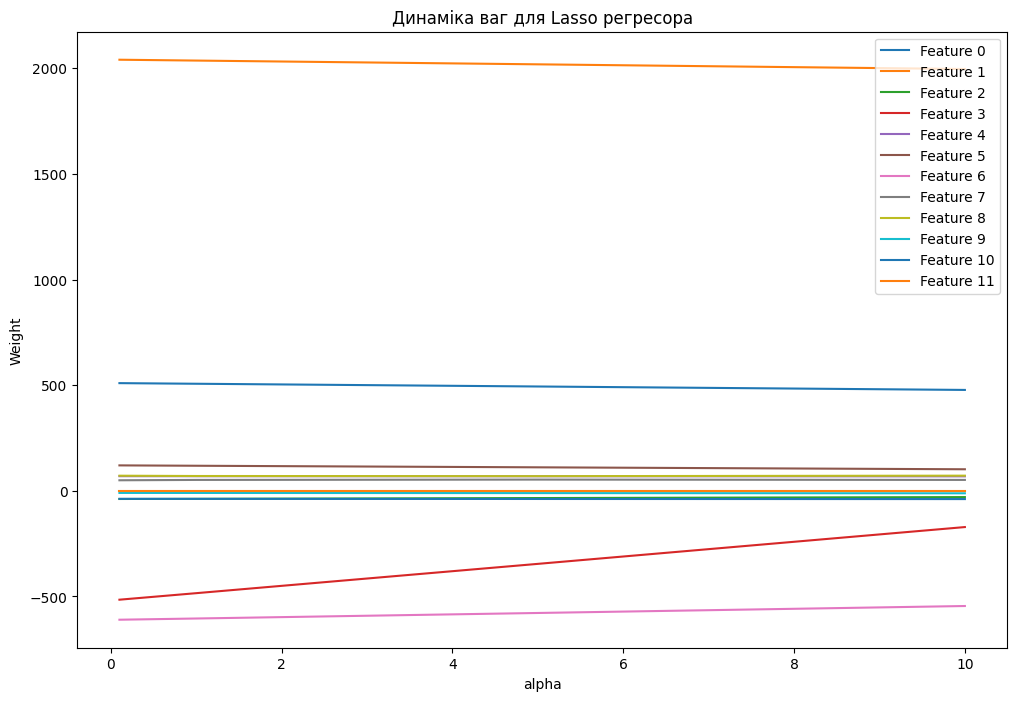

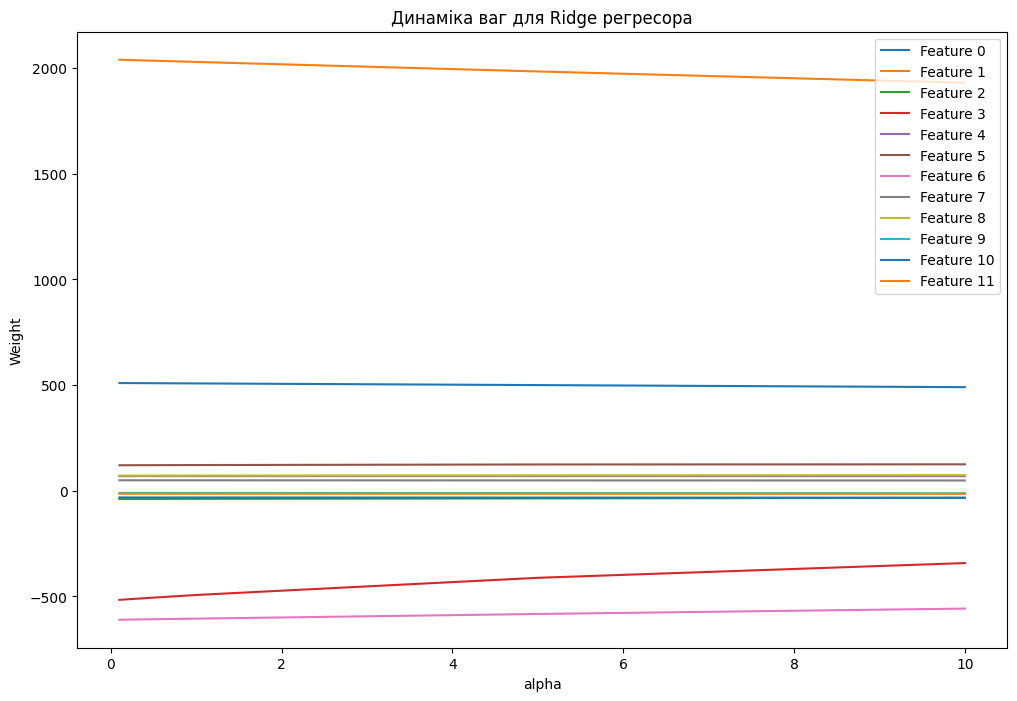

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

alphas = [0.1, 0.5, 1, 5, 10]

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

plt.figure(figsize=(12, 8))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alphas, coefs_lasso[:, i], label=f'Feature {i}')

plt.title('Динаміка ваг для Lasso регресора')
plt.xlabel('alpha')
plt.ylabel('Weight')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(coefs_ridge.shape[1]):
    plt.plot(alphas, coefs_ridge[:, i], label=f'Feature {i}')

plt.title('Динаміка ваг для Ridge регресора')
plt.xlabel('alpha')
plt.ylabel('Weight')
plt.legend()
plt.show()


Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1.Регуляризація Lasso зменшує ваги більш агресивно для тих самих значень альфа порівняно з Ridge; Lasso використовує регуляризацію L1 і прагне зменшити ваги до нуля, тоді як Ridge використовує регуляризацію L2 і прагне зменшити ваги, але не так сильно, як Lasso.
2.Зі збільшенням α ваги Лассо сходяться до нуля для більшості ознак. Це відбувається тому, що Лассо використовує регуляризацію L1, яка зводить деякі ваги до нуля. Збільшення значення альфа посилює цей ефект, спрощуючи модель і усуваючи деякі ознаки.
3.Так, Lasso вірогідно виключить одну з ознак windspeed за будь-якого значення alpha > 0, оскільки L1-регуляризація схильна до виключення деяких ознак. З іншого боку, Ridge, використовуючи L2-регуляризацію, не виключає ознак повністю, тенденція зменшення ваги, але не до нуля.
4.Методи регуляризації Лассо добре підходять для відбору неінформативних ознак; Лассо може зменшити вагу деяких ознак точно до нуля, ефективно видаляючи менш інформативні ознаки і спрощуючи модель. Ridge, з іншого боку, має тенденцію просто зменшувати ваги, але не до нуля.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

Вибране alpha: 1.3848863713938746

Пари 'ознака-коефіцієнт':
season: 505.3101834973658
yr: 2034.510874543941
mnth: -37.73132682276605
holiday: -471.43037033379574
weekday: 68.89123290668468
workingday: 117.71333549084098
weathersit: -602.0940298869557
temp: 52.06556176680793
atemp: 69.33379660126512
hum: -10.415966667600989
windspeed(mph): -38.40522043783739
windspeed(ms): -0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e+07, tolerance: 2.282e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e+08, tolerance: 2.047e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.659e+07, tolerance: 2.360e

Форма alphas: 100
Форма mse_values: 956626.0820126394


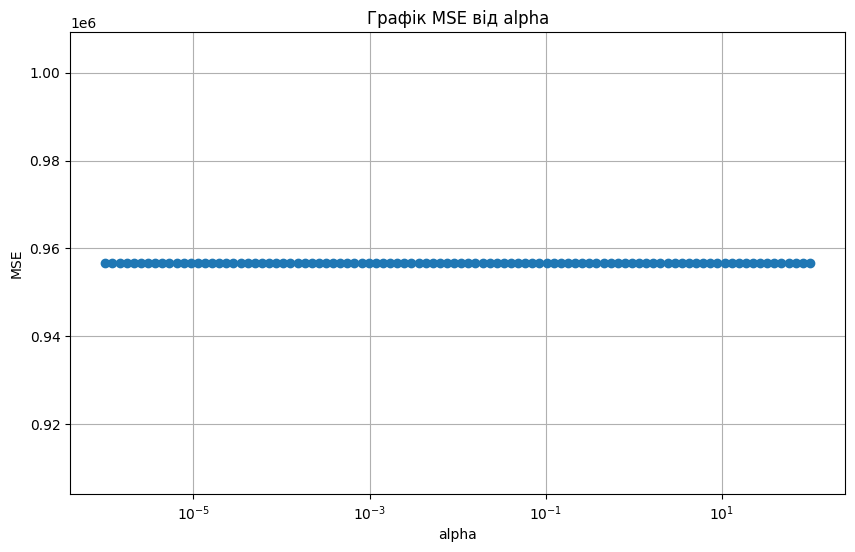

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

alphas = np.logspace(-6, 2, 100)


lasso_cv_regressor = LassoCV(alphas=alphas, cv=5)
lasso_cv_regressor.fit(X, y)

chosen_alpha = lasso_cv_regressor.alpha_
print(f"Вибране alpha: {chosen_alpha}")

coefficients = list(zip(X.columns, lasso_cv_regressor.coef_))
print("\nПари 'ознака-коефіцієнт':")
for feature, coefficient in coefficients:
    print(f"{feature}: {coefficient}")

mse_values = -cross_val_score(lasso_cv_regressor, X, y, cv=8, scoring='neg_mean_squared_error').mean()

print("Форма alphas:", len(alphas))
print("Форма mse_values:", mse_values)

def create_plot(alphas, mse_values, title, x_label, y_label):
    plt.figure(figsize=(10, 6))
    plt.semilogx(alphas, [mse_values] * len(alphas), marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

create_plot(alphas, mse_values, 'Графік MSE від alpha', 'alpha', 'MSE')


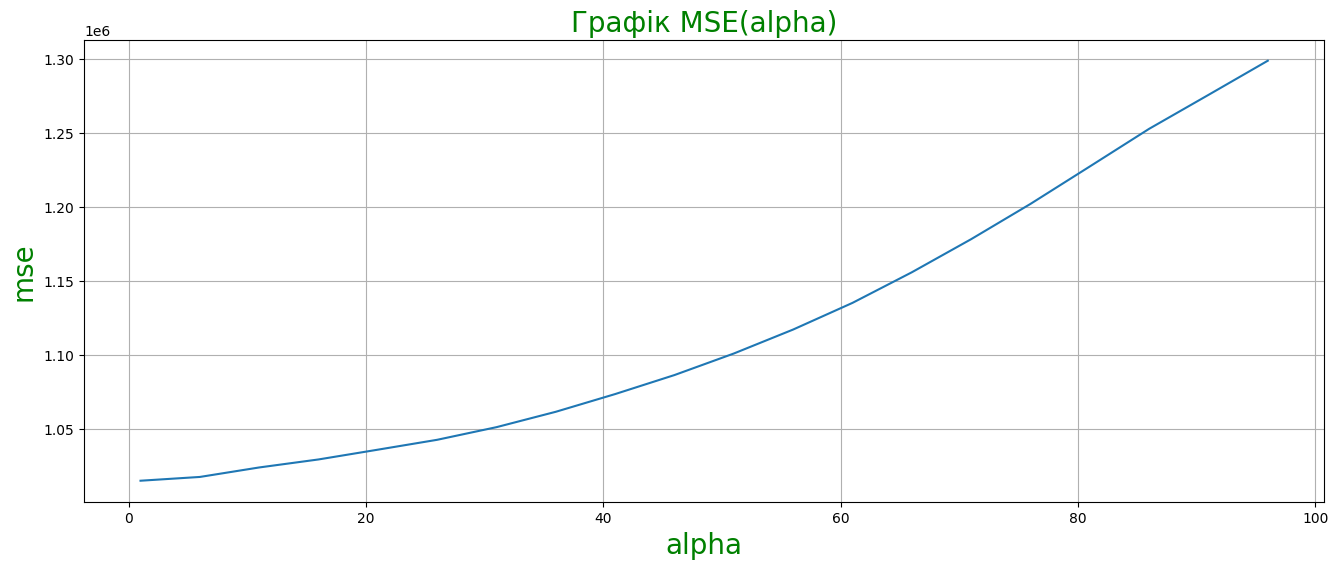

Alpha = 1
[('season', 506.5512786498074), ('yr', 2036.2316676979037), ('mnth', -38.07827028932167), ('holiday', -484.65194618654056), ('weekday', 68.93837479133958), ('workingday', 118.4475975866837), ('weathersit', -604.5667118927049), ('temp', 51.363260585616366), ('atemp', 69.91273749012187), ('hum', -10.352705204636573), ('windspeed(mph)', -38.34106761310847), ('windspeed(ms)', -0.0)]


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (16, 6)
plt.plot(regressor.alphas_, mse)
plt.title('Графік MSE(alpha)', fontsize=20, color='g')
plt.xlabel("alpha", fontsize=20, color='g')
plt.ylabel("mse", fontsize=20, color='g')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
print(list(zip(df.columns, regressor.coef_)))


### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Значення alpha для мінімумів MSE на кожному розбитті:
[51  1 96  1  1]


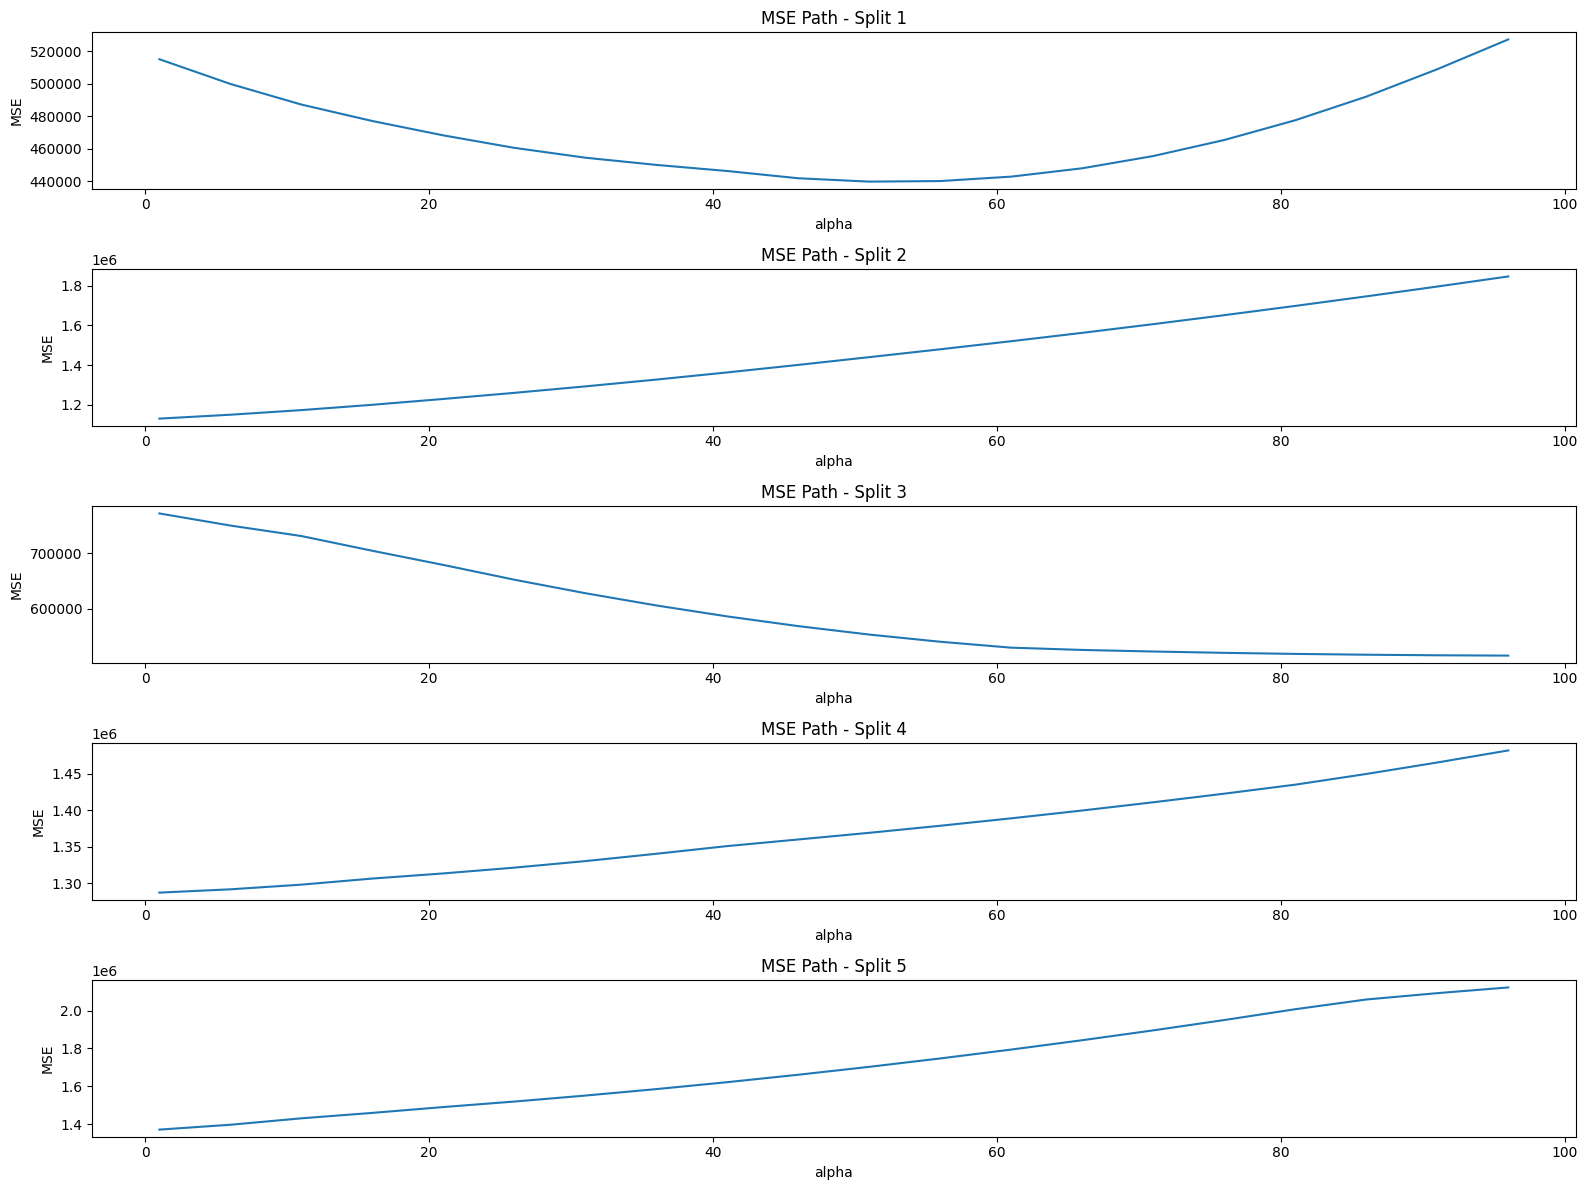

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

df = pd.read_csv('bikes_rent.csv')

X = df.drop('cnt', axis=1)
y = df['cnt']

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5).fit(X, y)

mse = regressor.mse_path_

min_alpha_indices = np.argmin(mse, axis=0)
min_alpha_values = regressor.alphas_[min_alpha_indices]

print("Значення alpha для мінімумів MSE на кожному розбитті:")
print(min_alpha_values)

plt.figure(figsize=(16, 12))

for i in range(mse.shape[1]):
    plt.subplot(mse.shape[1], 1, i + 1)
    plt.plot(regressor.alphas_, mse[:, i])
    plt.title(f'MSE Path - Split {i + 1}')
    plt.xlabel('alpha')
    plt.ylabel('MSE')

plt.tight_layout()
plt.show()


### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1.
2.

In [ ]:
#Додайте код, якщо потрібно

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1.
weathersit (оцінка сприятливості погоди)
windspeed(mph) (швидкість вітру в милях на годину)
hum (вологість)
2. На графіку видно, що кількість орендованих велосипедів ('cnt') зменшується зі збільшенням значень 'погода', 'швидкість вітру (миль/год)' та 'вологість'. Це може свідчити про те, що погана погода, сильний вітер і висока вологість негативно впливають на бажання людей брати велосипеди напрокат. Тому логічно припустити, що чим вищі значення цих атрибутів, тим менша ймовірність того, що люди візьмуть велосипед напрокат.

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1.windspeed(ms): -0.0
2. Параметр "швидкість вітру(мс)" майже ідентичний параметру "швидкість вітру(миль/год)", але виключений з моделі через різні одиниці виміру (метри за секунду та милі за годину). Оскільки ці дві ознаки лінійно пов'язані і роблять однаковий внесок у прогноз, одну з них можна виключити, щоб уникнути мультиколінеарності та зайвого навантаження на модель. Такий вибір покращує інтерпретацію та ефективність моделі, спрощуючи її структуру.
3. Отже, можна сказати, що "швидкість вітру (мс)" і "швидкість вітру (миль/год)" мало впливають на попит на велосипеди, оскільки вони майже ідентичні з точки зору інформативності. Обидва вимірюють швидкість вітру, але тільки в різних одиницях. Модель обирає одну з них (в даному випадку "швидкість вітру (мс)") та ігнорує іншу, щоб уникнути зайвої складності та надмірного налаштування.

Ознаки, які обирає модель, залежать від багатьох факторів, зокрема від налаштувань моделі та особливостей оптимізації. У цьому випадку вибрані характеристики (`windspeed(ms)`) виражені в одиницях СІ, що може бути простіше для інтерпретації.

### Висновок
напишіть висновок

У ході цього дослідження ми проаналізували та обробили дані про оренду велосипедів за допомогою бібліотеки Python Pandas. Було досліджено залежність частоти прокату від різних атрибутів, таких як місяць, температура, вологість та швидкість вітру.

На основі цих даних ми навчили лінійну регресійну модель для прогнозування кількості прокатів. Для покращення якості моделі та уникнення надмірної підгонки було використано регуляризацію L1 (Lasso) та L2 (Ridge).

Важливим кроком було дослідження впливу окремих характеристик на цільові змінні. Зокрема, було проаналізовано коефіцієнти регресії та їхні знаки для різних ознак. Цей аналіз був використаний для визначення того, які ознаки мають найбільший і найменший вплив на попит на велосипеди.

Також було досліджено вплив регуляризації на модель шляхом порівняння регресорів Ridge і Lasso та вивчення графіків зміни вагових коефіцієнтів зі збільшенням параметрів регуляризації.

Загалом, робота дозволила глибше зрозуміти фактори, що впливають на попит на велосипеди, а також розвинула навички роботи з Pandas, візуалізації даних та побудови і налаштування лінійних регресійних моделей на Python.